# Курсовой проект
Цель: Требуется построить модель на основании имеющихся данных о клиентах банка для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.
### Наименование файлов с данными
course_project_train.csv - обучающий датасет
course_project_test.csv - тестовый датасет
### Целевая переменная
Credit Default - факт невыполнения кредитных обязательств
### Метрика качества
F1-score (sklearn.metrics.f1_score)
### Требования к решению
Целевая метрика
F1 > 0.5
Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

### Описание датасета
Home Ownership - домовладение<br>
Annual Income - годовой доход<br>
Years in current job - количество лет на текущем месте работы<br>
Tax Liens - налоговые обременения, категориальная переменная<br>
Number of Open Accounts - количество открытых счетов<br>
Years of Credit History - количество лет кредитной истории<br>
Maximum Open Credit - наибольший открытый кредит<br>
Number of Credit Problems - количество проблем с кредитом<br>
Months since last delinquent - количество месяцев с последней просрочки платежа<br>
Bankruptcies - банкротства<br>
Purpose - цель кредита<br>
Term - срок кредита<br>
Current Loan Amount - текущая сумма кредита<br>
Current Credit Balance - текущий кредитный баланс<br>
Monthly Debt - ежемесячный долг<br>
Credit Score  -- насколько хорошо клиент возвращает кредит<br>
Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)<br>

#### Подключение библиотек

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
import xgboost as xgb, catboost as catb


import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
%autosave 180

Autosaving every 180 seconds


In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [3]:
import warnings
warnings.simplefilter('ignore')

#### Путь к директориям и файлам

In [4]:
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'

#### Загрузка данных

In [5]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.tail(5)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
7495,Rent,402192.0,< 1 year,0.0,3.0,8.5,107866.0,0.0,NaN,0.0,other,Short Term,129360.0,73492.0,1900.0,697.0,0
7496,Home Mortgage,1533984.0,1 year,0.0,10.0,26.5,686312.0,0.0,43.0,0.0,debt consolidation,Long Term,444048.0,456399.0,12783.0,7410.0,1
7497,Rent,1878910.0,6 years,0.0,12.0,32.1,1778920.0,0.0,NaN,0.0,buy a car,Short Term,99999999.0,477812.0,12479.0,748.0,0
7498,Home Mortgage,NaN,NaN,0.0,21.0,26.5,1141250.0,0.0,NaN,0.0,debt consolidation,Short Term,615274.0,476064.0,37118.0,NaN,0
7499,Rent,NaN,4 years,0.0,8.0,9.4,480832.0,0.0,NaN,0.0,debt consolidation,Short Term,26928.0,288192.0,9061.0,NaN,0


In [6]:
df_train.shape

(7500, 17)

In [7]:
df_train.iloc[14]

Home Ownership                     Own Home
Annual Income                    2.2588e+06
Years in current job                7 years
Tax Liens                                 0
Number of Open Accounts                  11
Years of Credit History                17.7
Maximum Open Credit             1.60255e+06
Number of Credit Problems                 0
Months since last delinquent            NaN
Bankruptcies                              0
Purpose                               other
Term                             Short Term
Current Loan Amount                  185262
Current Credit Balance          1.37433e+06
Monthly Debt                          58352
Credit Score                            748
Credit Default                            0
Name: 14, dtype: object

In [8]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [9]:
df_test.shape

(2500, 16)

In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
Home Ownership                  7500 non-null object
Annual Income                   5943 non-null float64
Years in current job            7129 non-null object
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    3419 non-null float64
Bankruptcies                    7486 non-null float64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    5943 non-null float64
Credit Default                  7

### Типы данных

In [11]:
df_train.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

Категореальные переменные: 
Home Ownership
Years in current job
Bankruptcies
Purpose
Tax Liens
Term
Purpose
Credit Default

Tax Liens категориальная переменная, однако ее тип float64. Приведем ее к int типу. 

In [12]:
df_train['Tax Liens'] = df_train['Tax Liens'].astype(int)
df_test['Tax Liens'] = df_test['Tax Liens'].astype(int)

### Обзор данных

**Обзор целевой переменной**

In [13]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_train.columns.drop(TARGET_NAME).tolist()

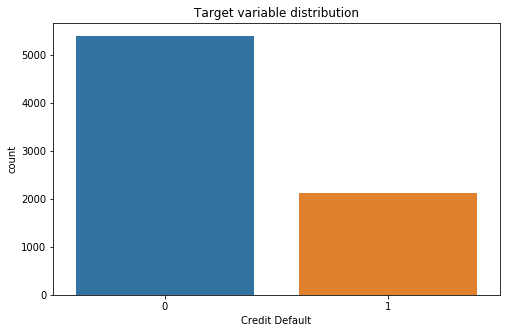

In [14]:
plt.figure(figsize=(8, 5))

sns.countplot(x=TARGET_NAME, data=df_train)

plt.title('Target variable distribution')
plt.show()

In [15]:
df_train[TARGET_NAME].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

Отсюда видно, что данные несбалансированные, больше возвратов кредита вовремя, чем просрочки платежа.<br>
Посмотрим на числовые переменные в датасете:

In [16]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


Посмотрим на номинальные переменные:

In [17]:
for col_name in df_train.select_dtypes(include='object').columns:
    print(str(col_name)+'\n'+str(df_train[col_name].value_counts()))

Home Ownership
Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
Years in current job
10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
Purpose
debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64
Term
Short Term    5556
Long Term     1944
Name: Term, dtype: int64


#### Пропуски

In [18]:
len(df_train) - df_train.count()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

1) Видно, что больше половины значений нет в колонке Months since last delinquent. Возможно, просрочки платежа у этих 4081 не было, поэтому NaN сможем заменить на 0, для определенности. <br>
df_train['Months since last delinquent'] = df_train['Months since last delinquent'].fillna(0)

2) Credit Score и Annual Income имеют подозрительно похожее количество пропусков, 1557, но пока неясно что с ними делать. С одной стороны, это могут быть люди, которые только присоединились к рабочему сообществу и если годовой доход берется не из договора о найме, а из истории человека, который уже получал эти деньги, то возможно, это люди, которые работают первые полтора года. Но, исходя из наших данных, клиентов трудоустроенных менее двух лет меньше тысячи. <br> 
можно, например, заменить пропуски на медианы.

3) Years in current job не хватает 371 значения, это несколько процетов, добьем медианой, перед этим переведем значения в числовые. <br>

4) Bankruptcies всего 14 пропусков, заменим их на самое популярное значение, чтобы не зашумлять данные, то есть на 0.

In [19]:
df_train['Bankruptcies'].value_counts(dropna = False)

0.0    6660
1.0     786
2.0      31
NaN      14
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

In [20]:
df_train['Bankruptcies'] = df_train['Bankruptcies'].fillna(0)
df_test['Bankruptcies'] = df_test['Bankruptcies'].fillna(0) 

In [21]:
df_train['Months since last delinquent'] = df_train['Months since last delinquent'].fillna(0)
df_test['Months since last delinquent'] = df_test['Months since last delinquent'].fillna(0)

In [22]:
df_train['Credit Score'] = df_train['Credit Score'].fillna(df_train['Credit Score'].mode())
df_test['Credit Score'] = df_test['Credit Score'].fillna(df_test['Credit Score'].mode())

In [23]:
df_train['Annual Income'] = df_train['Annual Income'].fillna(df_train['Annual Income'].mode())
df_test['Annual Income'] = df_test['Annual Income'].fillna(df_test['Annual Income'].mode())

In [24]:
df_train['Years in current job'].value_counts()

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

In [25]:
df_test['Years in current job'].value_counts()

10+ years    810
3 years      228
2 years      212
< 1 year     207
5 years      169
1 year       153
4 years      152
7 years      140
6 years      137
8 years      107
9 years       99
Name: Years in current job, dtype: int64

Переведем в числовые значения, чтобы заполнить пропуски медианой:

In [26]:
Years_in_current_job_dict = {'10+ years':10, '9 years':9, '8 years':8,
                             '7 years':7, '6 years':6,'5 years':5, '4 years':4,
                             '3 years':3, '2 years':2, '1 year':1, '< 1 year':0}

In [27]:
df_train['int Years in current job'] = df_train['Years in current job'].map(Years_in_current_job_dict)
df_test['int Years in current job'] = df_test['Years in current job'].map(Years_in_current_job_dict)

In [28]:
df_train['int Years in current job'] = df_train['int Years in current job'].fillna(df_train['int Years in current job'].mode()[0])
df_test['int Years in current job'] = df_test['int Years in current job'].fillna(df_test['int Years in current job'].mode()[0])

In [29]:
len(df_test['int Years in current job']) - df_test['int Years in current job'].count()

0

#### Выбросы

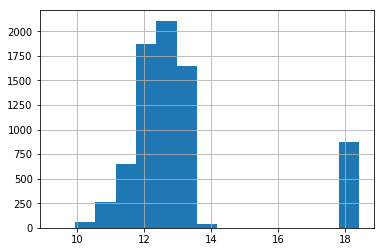

In [30]:
df_train['Current Loan Amount'].apply(np.log).hist(bins=15)

Вывод: есть выбросы в 'Current Loan Amount', можно их убрать при
построении корреляций и надо их обработать, так как из матрицы корреляций ниже видно, что это существенный признак.

In [31]:
df_train['Current Loan Amount'].max()

99999999.0

**Корреляция с базовыми признаками**

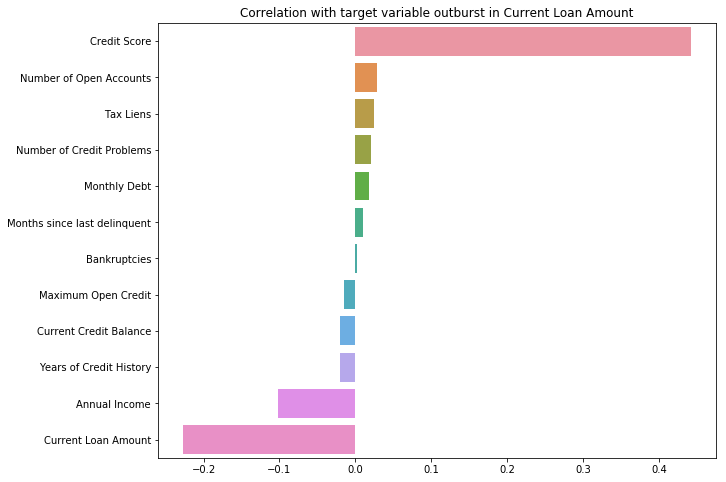

In [32]:
corr_with_target = df_train[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable outburst in Current Loan Amount')
plt.show()

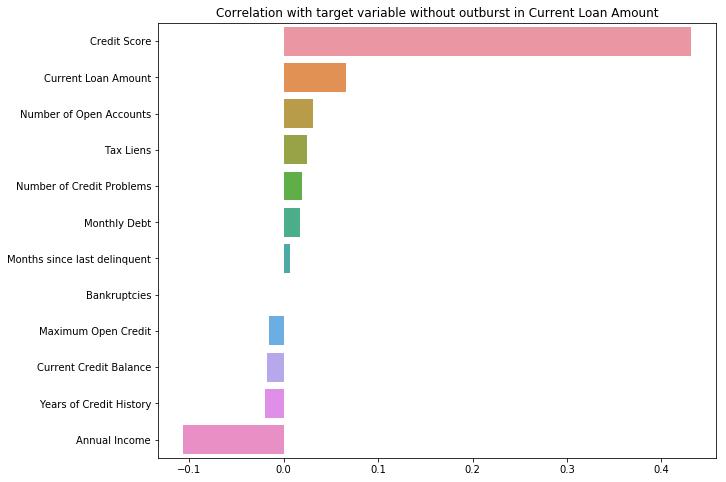

In [33]:
corr_with_target = \
df_train[df_train['Current Loan Amount'] != 99999999][BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable without outburst in Current Loan Amount')
plt.show()

### Анализ признакового пространства

In [34]:
df_train['Purpose'].value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

In [35]:
Purpose_dict = {'debt consolidation': 0, 'other': 1, 'home improvements': 2, 'business loan': 3, 'buy a car': 4,
               'medical bills': 5, 'major purchase': 6, 'take a trip': 7, 'buy house': 8, 'small business': 9, 
               'wedding': 10, 'moving': 11, 'educational expenses': 12, 'vacation': 13, 'renewable energy': 14}

In [36]:
df_train['int Purpose'] = df_train['Purpose'].map(Purpose_dict)
df_test['int Purpose'] = df_test['Purpose'].map(Purpose_dict)

In [37]:
df_train['Home Ownership'].value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

In [38]:
Home_Ownership_dict = {'Home Mortgage': 0, 'Rent': 1, 'Own Home': 2, 'Have Mortgage': 3}
df_train['int Home Ownership'] = df_train['Home Ownership'].map(Home_Ownership_dict)
df_test['int Home Ownership'] = df_test['Home Ownership'].map(Home_Ownership_dict)

In [39]:
df_train['Term'].value_counts()

Short Term    5556
Long Term     1944
Name: Term, dtype: int64

In [40]:
Term_dict = {'Short Term': 0, 'Long Term': 1}
df_train['int Term'] = df_train['Term'].map(Term_dict)
df_test['int Term'] = df_test['Term'].map(Term_dict)

In [41]:
BASE_FEATURE_NAMES.append('int Home Ownership')
BASE_FEATURE_NAMES.remove('Home Ownership')
BASE_FEATURE_NAMES.append('int Purpose')
BASE_FEATURE_NAMES.remove('Purpose')
BASE_FEATURE_NAMES.append('int Term')
BASE_FEATURE_NAMES.remove('Term')
BASE_FEATURE_NAMES.append('int Years in current job')
BASE_FEATURE_NAMES.remove('Years in current job')

In [42]:
df_train[BASE_FEATURE_NAMES].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 16 columns):
Annual Income                   5943 non-null float64
Tax Liens                       7500 non-null int64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    7500 non-null float64
Bankruptcies                    7500 non-null float64
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    5943 non-null float64
int Home Ownership              7500 non-null int64
int Purpose                     7500 non-null int64
int Term                        7500 non-null int64
int Years in current job        7500 non-null float64
dtypes: float64(12), int64(4)
memory 

#### Коррелляция со всеми признаками в числовом формате

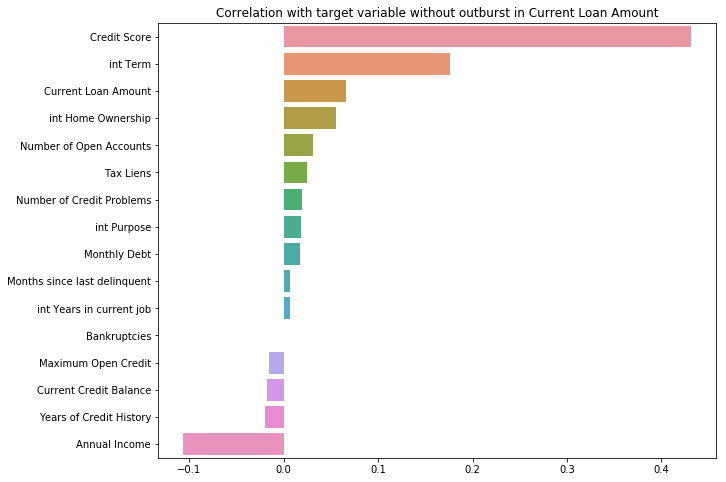

In [43]:
corr_with_target = \
df_train[df_train['Current Loan Amount'] != 99999999][BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable without outburst in Current Loan Amount')
plt.show()

Сами беспреспективными признакми выглядит: Bankruptcies. Удалим:

In [44]:
BASE_FEATURE_NAMES.remove('Bankruptcies')

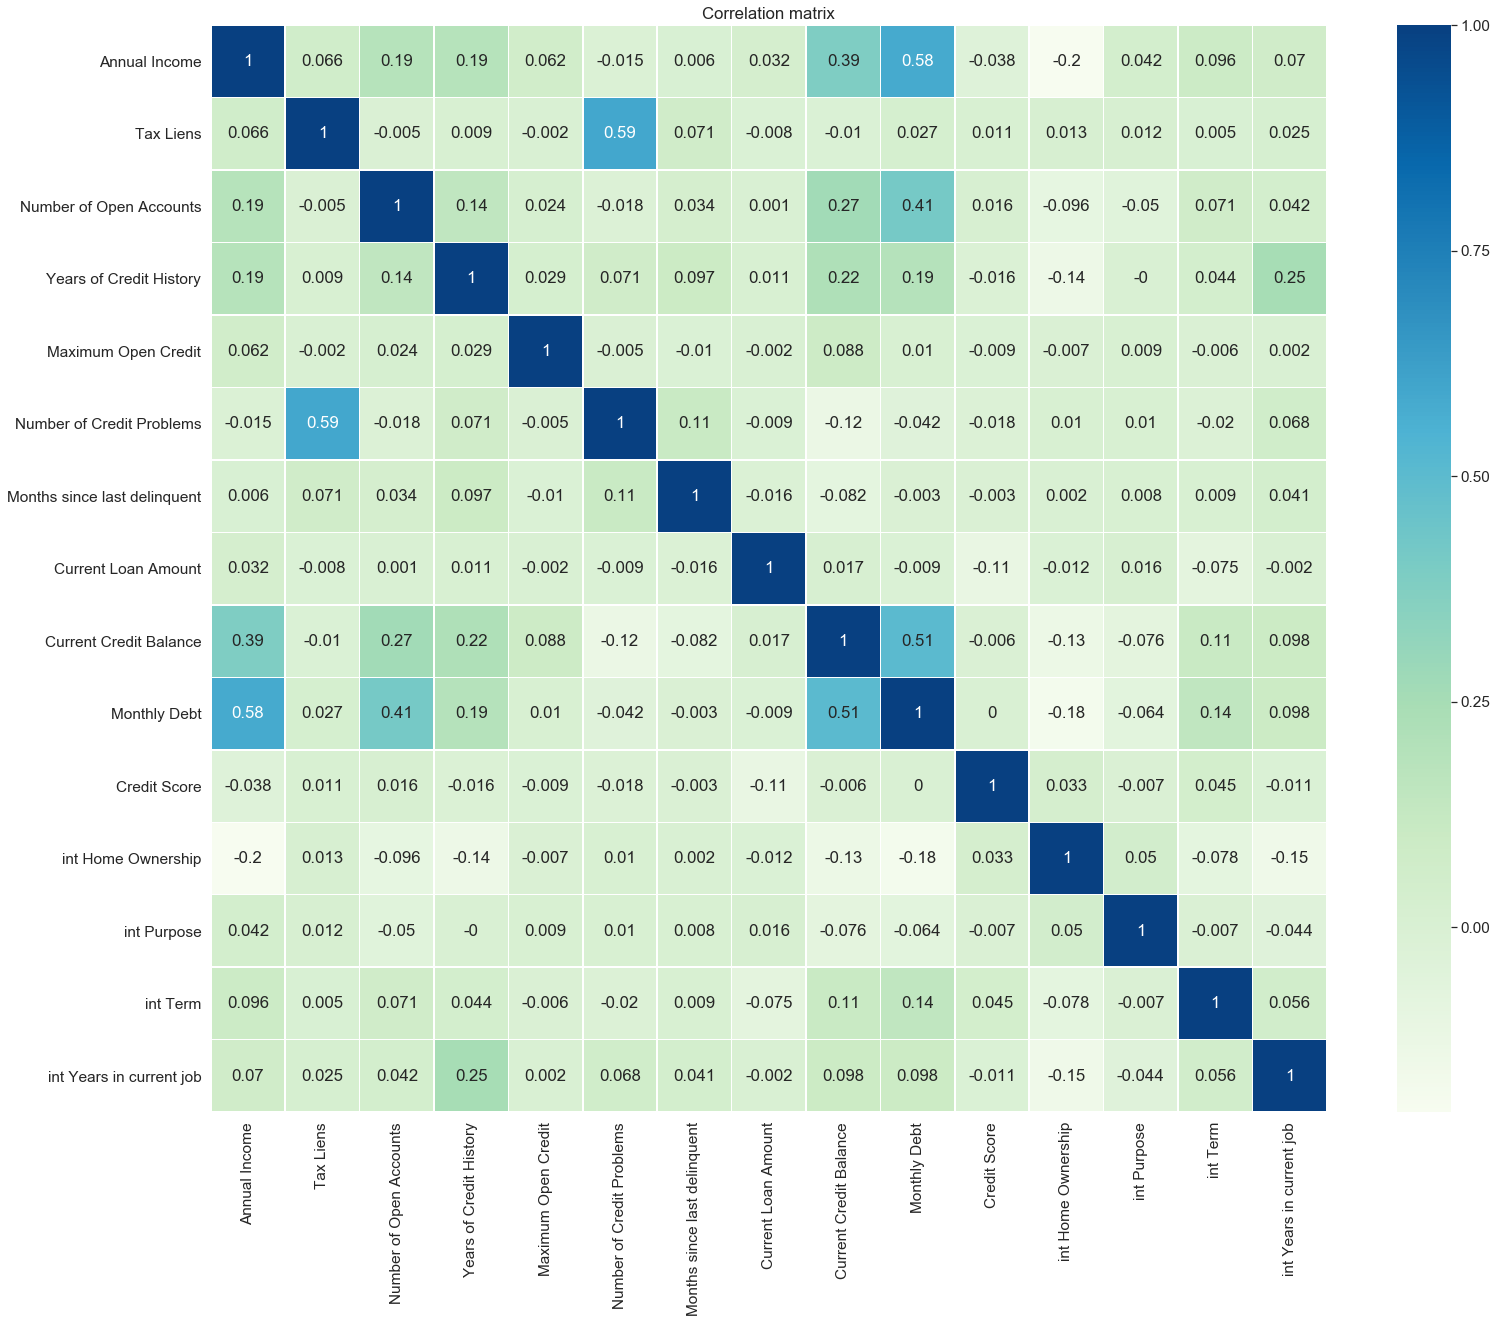

In [45]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)
sns.heatmap(df_train[BASE_FEATURE_NAMES].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

In [46]:
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, roc_auc_score as auc, SCORERS
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

In [47]:
df_test[BASE_FEATURE_NAMES].describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,int Home Ownership,int Purpose,int Term,int Years in current job
count,1.988000e+03,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,2500.000000,2.500000e+03,2.500000e+03,2500.000000,1988.000000,2500.00000,2500.000000,2500.000000,2500.000000
mean,1.366750e+06,0.035200,11.184400,18.325920,7.105704e+05,0.162000,15.614000,1.215572e+07,2.963966e+05,18271.340000,1234.271127,0.61480,0.534400,0.255600,6.089200
std,9.169264e+05,0.386291,4.852774,7.254659,1.511983e+06,0.559894,22.616348,3.226097e+07,3.783020e+05,11543.881469,1739.815985,0.67246,1.478949,0.436285,3.648913
min,1.065330e+05,0.000000,1.000000,3.900000,0.000000e+00,0.000000,0.000000,1.542200e+04,0.000000e+00,93.000000,585.000000,0.00000,0.000000,0.000000,0.000000
25%,8.523828e+05,0.000000,8.000000,13.400000,2.785860e+05,0.000000,0.000000,1.871265e+05,1.101145e+05,10024.750000,710.000000,0.00000,0.000000,0.000000,3.000000
50%,1.178361e+06,0.000000,10.000000,17.000000,4.786760e+05,0.000000,0.000000,3.223660e+05,2.073850e+05,16642.500000,731.000000,1.00000,0.000000,0.000000,6.000000
75%,1.629388e+06,0.000000,14.000000,22.100000,8.025985e+05,0.000000,27.000000,5.225825e+05,3.663485e+05,24146.000000,743.000000,1.00000,0.000000,1.000000,10.000000
max,1.497561e+07,15.000000,48.000000,53.400000,5.448439e+07,15.000000,82.000000,1.000000e+08,6.030087e+06,93555.000000,7480.000000,3.00000,13.000000,1.000000,10.000000


In [91]:
df  = df_train.copy()

In [92]:
scaler = StandardScaler()

In [93]:
poly = PolynomialFeatures(2)

In [94]:
df_tst = df_test.copy()

In [95]:
df[feats] = scaler.fit_transform(df[feats].fillna(0))
df_tst[feats] = scaler.transform(df_tst[feats].fillna(0))

In [96]:
nd = np.hstack([poly.fit_transform(df[feats]),np.array(df[TARGET_NAME]).reshape(-1, 1)])
train, valid = train_test_split(nd, \
                                test_size=0.3, random_state=3, stratify=df[TARGET_NAME])

In [97]:
ndtst = poly.fit_transform(df_tst[feats])

In [98]:
nd.std()


6.890135991746873

### Baseline

In [50]:
train, valid = train_test_split(df, test_size=0.3, random_state=0, stratify=df[TARGET_NAME])

In [51]:
def eval_model(trn, tst, feats, trsh, model):
    # Оценка метрик модели 
    
    model.fit(trn[feats], trn[TARGET_NAME])
    
    pred_trn_p = model.predict_proba(trn.loc[:, feats]).T[1]
    pred_trn = (model.predict_proba(trn.loc[:, feats]).T[1] > trsh).astype('int')
    auc_trn = auc(trn[TARGET_NAME], pred_trn_p)
    f1_trn =  f1_score(trn[TARGET_NAME], pred_trn)
    
    pred_tst_p = model.predict_proba(tst.loc[:, feats]).T[1]
    pred_tst = (model.predict_proba(tst.loc[:, feats]).T[1] > trsh).astype('int')
    auc_tst = auc(tst[TARGET_NAME], pred_tst_p)
    f1_tst =  f1_score(tst[TARGET_NAME], pred_tst)
    
    return auc_trn, auc_tst, f1_trn, f1_tst, model

In [52]:
train=train.fillna(0)
valid=valid.fillna(0)

In [53]:
feats = BASE_FEATURE_NAMES.copy()

In [54]:
lr_model  = LogisticRegression(random_state=0, solver='liblinear')
auc_trn, auc_tst, f1_trn, f1_tst, rf = eval_model(train, valid, feats, 0.27, lr_model)
auc_trn, auc_tst, f1_trn, f1_tst

(0.7139697657060063, 0.7220119389699222, 0.4998967155546374, 0.51171875)

In [ ]:
feats

### Байес

In [56]:
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
nb_model = GaussianNB()

In [57]:
auc_trn, auc_tst, f1_trn, f1_tst, rf = eval_model(train, valid, feats, 0.53, nb_model)
auc_trn, auc_tst, f1_trn, f1_tst

(0.6818125013335283,
 0.6766522472436518,
 0.48579690423541416,
 0.4920508744038156)

### CatBoost

In [63]:
feats = BASE_FEATURE_NAMES.copy()

In [64]:
import catboost as catb
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV

In [65]:
train, valid = train_test_split(df, test_size=0.3, random_state=70, stratify=df[TARGET_NAME])

In [66]:
catb_model = catb.CatBoostClassifier(class_weights=[1, 3.3], silent=True, random_state=70,
                                     cat_features=['int Home Ownership', 'int Term', 'int Purpose'])

In [67]:
cv = KFold(n_splits=5, random_state=21, shuffle=True)

In [68]:
X, y = df[feats].fillna(0), df[TARGET_NAME]

In [69]:
params = {'max_depth':[3, 4, 5],
          'n_estimators': [ 75, 80, 85],
          'learning_rate': [0.12, 0.15, 0.17]}

In [70]:
rs = RandomizedSearchCV(lr_model, {}, scoring='roc_auc', cv=cv, n_jobs=1, random_state=70)

In [73]:
train, valid = train_test_split(df, test_size=0.3, random_state=70, stratify=df[TARGET_NAME])

In [74]:
auc_trn, auc_tst, f1_trn, f1_tst, rf = eval_model(train, valid, feats, 0.56, catb_model)
auc_trn, auc_tst, f1_trn, f1_tst

(0.9655427016864226,
 0.7456917418871225,
 0.8283696653361989,
 0.5155893536121674)

### XGBoost

In [75]:
import xgboost as xgb

In [76]:
train, valid = train_test_split(df, test_size=0.3, random_state=70, stratify=df[TARGET_NAME])

In [78]:
xgb_model = xgb.XGBClassifier(max_depth=3, min_child_weight=7, colsample_bytree=0.27)

In [79]:
auc_trn, auc_tst, f1_trn, f1_tst, rf = eval_model(train, valid, feats, 0.24, xgb_model)
auc_trn, auc_tst, f1_trn, f1_tst

(0.8289576568198033,
 0.7565682879407813,
 0.5863416877443091,
 0.5285029302077784)

### Random Forest

In [81]:
from sklearn.ensemble import RandomForestClassifier as RF

In [102]:
train, valid = train_test_split(df, test_size=0.3, random_state=70, stratify=df[TARGET_NAME])

In [105]:
n_est=20
mx_d=13
rnd_st=70
rf_model = RF(n_estimators=n_est, max_depth=mx_d, random_state=rnd_st)

In [106]:
auc_trn, auc_tst, f1_trn, f1_tst, rf = eval_model(train, valid, feats, 0.5, rf_model)
auc_trn, auc_tst, f1_trn, f1_tst

(0.9812992251281039, 0.7282654527282382, 0.7528230865746549, 0.417233560090703)

In [125]:
final_model = rf_model
trsh = 0.285
pred_test = (final_model.predict_proba(df_tst.loc[:, feats]).T[1] > trsh).astype('int')

In [127]:
df_tst['Credit Default'] = pred_test

In [128]:
df_tst.loc[:, ['Credit Default']].to_csv('AKonyshevapredictions.csv', index=None)